<h1> <center> Application of Deep Learning for PDEs :</center> </h1>


Welcome to this notebook, which demonstrates a brief session on the second part of the course **Machine Learning in Finance: Theoretical Foundations** about **Deep Learning for PDE**. 
This notebook aims to showcase how some algorithms introduced during the course can be efficiently implemented in Python using various libraries, and how it can be applied to PDE arising in finance.

<h2> Summary of the lecture : </h2>

- [Some applications of Deep Galerkin in Finance](#galerkin-Applications)
  - [A reminder of the method and algorithm](#galerkin-reminder)
  - [Some Numerical Results](#galerkin-results)
- [Some applications of Deep BSDE Algorithm](#deepBSDE-Applications)
  - [A reminder of the method and algorithm](#deepBSDE-reminder)
  - [Some Numerical Results](#deepBSDE-results)
- [References](#references)

In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions.normal import Normal

import math
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


<a id=galerkin-Applications></a>

<h2> <center> Some applications of Deep Galerkin Algorithm in Finance </h2> </center>


We are giving to present some applications of the Deep Galerkin algorithm for solving PDEs in a general form :

$$
\begin{align}\tag{1}
\partial_v (t,x) = \mathcal{H}[v](t,x) \quad (t,x) \in [0,T) \times \mathbb{R}^d \\
v(T,x) = g(x) , \quad x \in \mathbb{R}^d 
\end{align}
$$
where $\mathcal{H}$ is an operator which can contain multiples derivatives of $v$ with respect to $x$.


Given a function $w$ on $[0,T] \times \mathbb{R}^d$ , we define :

$$
\begin{align}\tag{2}
\mathbb{L}(\omega) = \mathbb{E}[|w(T,\mathcal{X}) -g(\mathcal{X})|^2] + \mathbb{E}[|\partial_t \omega(\tau,\mathcal{X}) - \mathcal{H}[\omega](\tau,\mathcal{X})|^2]
\end{align}
$$

where $(\tau,\mathcal{X})$ are independant random variables $\sim v_T \otimes v_d$ supported on $[0,T] \times \mathbb{R}^d$

From the definition of $v$, it is clear that $v$ is a solution to (1) if and only if v achieves the minimum of $\mathbb{L}$.

<a id=galerkin-reminder></a>

<h3>A reminder of the method and algorithm </h3>


As the optimization problem (2) is numerically infeasible, we can look to approximate $v$ using the finite dimensionnal class of neural networks parametrized by $\theta$ noted $\mathcal{U}_{\theta}$. We look therefore to solve the following problem :

\begin{align}
\underset{\theta}{\text{ inf }} \mathbb{L}(\mathcal{U}_{\theta})
\end{align}


<a id=galerkin-results></a>

<h3> Some Numerical Results : </h3> 

In [186]:
# Imports


r = 0.02
sigma = 0.2
    
plt.figure(dpi=600)
plt.rcParams['figure.figsize'] = [12, 8]


class CallTrade():
    def __init__(self, K, T,q):
        self.T = T # Maturité
        self.K = K # Strike
        self.q = q # Quantité

    def d_plus(self, St, t):
        return (torch.log(St/self.K) + (r + 0.5 * sigma**2) * torch.tensor(self.T-t)) / (sigma * torch.sqrt(torch.tensor(self.T-t)))

    def d_minus(self, St, t):
        return self.d_plus(St, t) - sigma * torch.sqrt(torch.tensor(self.T-t))

    def delta(self, St, t):
        delta = self.q * Normal(0, 1).cdf(self.d_plus(St, t))
        return delta

    def price(self, St, t):
        return self.q * (St * Normal(0, 1).cdf(self.d_plus(St, t)) - self.K * Normal(0, 1).cdf(self.d_minus(St, t)) * torch.exp(torch.tensor(-r*(self.T-t))))
    

class ForwardTrade():
    def __init__(self, K, T,q):
        self.T = T # Maturité
        self.K = K # Strike
        self.q = q # Quantité
    def price(self,St,t):
        return self.q* (St - self.K*torch.exp(torch.tensor(-r*(self.T-t))))


class Portfolio():
    def __init__(self, trades=[]):
        self.trades = trades

    def add_trade(self, trade):
        self.trades.append(trade)
        

        
        
portfolio = Portfolio([CallTrade(110, 1,1),])
portfolio2=Portfolio([ForwardTrade(100,1,1)])



<Figure size 7200x4800 with 0 Axes>

<h4> Defining the neural networks :  </h4>

In [ ]:
# Defining the Neural Network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.fc(x)

v_net = Net().to(device)
#w_net = Net().to(device)

# Fonction pour calculer les dérivées nécessaires
def compute_derivatives(net, S, T):
    S = S.requires_grad_()
    T = T.requires_grad_()
    net_input = torch.cat([T, S], dim=-1)
    output = net(net_input)
    output_grad = torch.autograd.grad(outputs=output, inputs=[T, S], grad_outputs=torch.ones_like(output),
                                      create_graph=True, allow_unused=True)
    d_output_dT = output_grad[0]
    d_output_dS = output_grad[1]

    # Ici, on recalcule output pour d_output_dS pour s'assurer que les gradients sont calculés correctement
    d2_output_dS2 = torch.autograd.grad(outputs=d_output_dS.sum(), inputs=S, create_graph=True)[0]

    return output, d_output_dT, d_output_dS, d2_output_dS2

In [114]:
def forward_terminal_condition(S,K):
    return S-K

def call_terminal_condition(S,K):
    positive_part = torch.max(S-K,torch.tensor(0.0))
    return positive_part


T_max = 1.0
S_max = 200.0
S_min = 20.0

num_t_points = 100
num_s_points = 100
batch_size = 1000  # Can be adjusted
epochs = 2000
learning_rate = 1e-2

<h4> A Forward Surface : </h4>

Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

Epoch 0, Train Loss: 1.1377, Val Loss: 6590.9907
Epoch 100, Train Loss: 13.3388, Val Loss: 14.5145
Epoch 200, Train Loss: 5.4469, Val Loss: 5.1077
Epoch 300, Train Loss: 14.3766, Val Loss: 17.7287
Epoch 400, Train Loss: 5.5532, Val Loss: 6.0482
Epoch 500, Train Loss: 14.8807, Val Loss: 14.9182
Epoch 600, Train Loss: 4.8899, Val Loss: 10.8458
Epoch 700, Train Loss: 0.6606, Val Loss: 0.7275
Epoch 800, Train Loss: 4.2933, Val Loss: 6.0720
Epoch 900, Train Loss: 1.4828, Val Loss: 0.6643
Epoch 1000, Train Loss: 10.5135, Val Loss: 6.6997
Epoch 1100, Train Loss: 2.2997, Val Loss: 4.8440
Epoch 1200, Train Loss: 0.5623, Val Loss: 1.7674
Epoch 1300, Train Loss: 1.5832, Val Loss: 3.1659
Epoch 1400, Train Loss: 15.3482, Val Loss: 12.4861
Epoch 1500, Train Loss: 0.2071, Val Loss: 0.2950
Epoch 1600, Train Loss: 2.2994, Val Loss: 3.7215
Epoch 1700, Train Loss: 4.4796, Val Loss: 5.6872
Epoch 1800, Train Loss: 6.0592, Val Loss: 6.0786
Epoch 1900, Train Loss: 3.6204, Val Loss: 4.7028
Epoch 1999, Train L

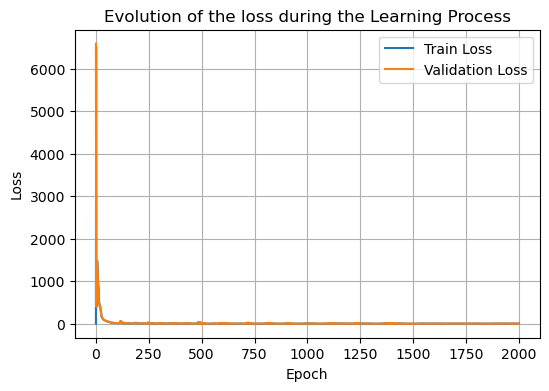

In [182]:
# Loss Function Definition
def loss_fn(S, T, v_net):
    v, dv_dt, dv_dS, d2v_dS2 = compute_derivatives(v_net, S, T)

    A_v = r * S * dv_dS + 0.5 * sigma ** 2 * S ** 2 * d2v_dS2


    loss_v = torch.mean((dv_dt + A_v - r * v)** 2)
    K=portfolio2.trades[0].K
    
    
    terminal_condition_v = forward_terminal_condition(S,K)

    loss_terminal_v = torch.mean(((v_net(torch.cat([torch.tensor([[T_max]] * S.shape[0]).to(device), S], dim=-1))-terminal_condition_v) ** 2))

    return loss_v  + loss_terminal_v

# Preparing data
T = torch.linspace(0.01, T_max, num_t_points).to(device)
S = torch.linspace(S_min, S_max, num_s_points).to(device)
T_grid, S_grid = torch.meshgrid(T, S, indexing='ij')
T_flat = T_grid.flatten().unsqueeze(1)  # Column Vector
S_flat = S_grid.flatten().unsqueeze(1)  # Column Vector

# Training and Validation Test
indices = torch.randperm(T_flat.size(0))
train_indices = indices[:int(0.8 * len(indices))]
val_indices = indices[int(0.8 * len(indices)):]

T_train, S_train = T_flat[train_indices], S_flat[train_indices]
T_val, S_val = T_flat[val_indices], S_flat[val_indices]

# Defining the optimizer
optimizer = optim.Adam(list(v_net.parameters()), lr=learning_rate)

# Training Procedure
train_losses = []
val_losses = []

from tqdm.notebook import tqdm

# Training Loop with tqdm to see evolution
for epoch in tqdm(range(epochs), desc="Training Progress"):
    optimizer.zero_grad()
    loss_train = loss_fn(S_train, T_train, v_net)
    loss_train.backward()
    optimizer.step()

    # Validation
    loss_val = loss_fn(S_val, T_val, v_net)

    train_losses.append(loss_train.item())
    val_losses.append(loss_val.item())

    # Plotting the training loss over epochs
    if epoch % 100 == 0 or epoch == epochs - 1:
        tqdm.write(f"Epoch {epoch}, Train Loss: {loss_train.item():.4f}, Val Loss: {loss_val.item():.4f}")

# Plotting loss functions

plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Evolution of the loss during the Learning Process")
plt.legend()
plt.grid()
plt.show()


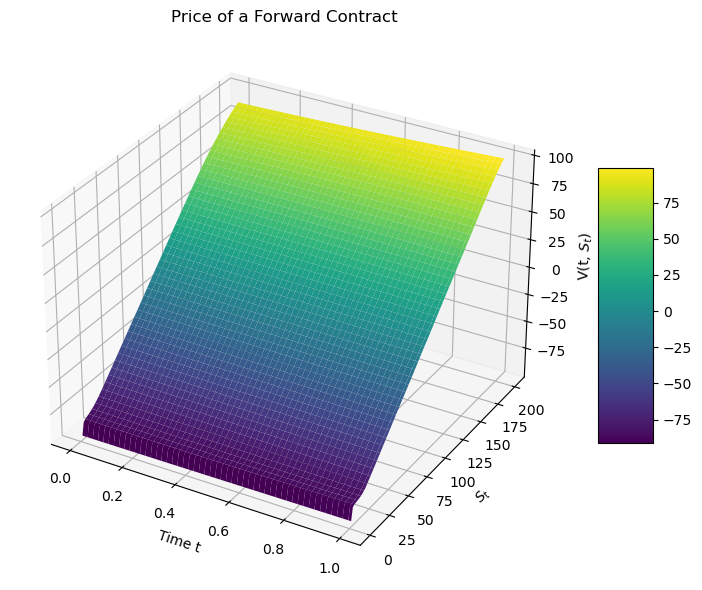

In [183]:
import numpy as np
import matplotlib.pyplot as plt


v_net.eval()

T_values = np.linspace(0, T_max, num_t_points)
S_values = np.linspace(0, S_max, num_s_points)
T_grid, S_grid = np.meshgrid(T_values, S_values)
points = torch.tensor(np.stack([T_grid.ravel(), S_grid.ravel()], axis=1), dtype=torch.float32).to(device)

# Evaluating the model over the points (t,x).
with torch.no_grad():
    v_pred = v_net(points).cpu().numpy().reshape(T_grid.shape)


    fig = plt.figure(figsize=(8,6))


ax = fig.add_subplot(1, 1,1, projection='3d')
surf = ax.plot_surface(T_grid[1:], S_grid[1:], v_pred[1:], cmap='viridis')
ax.set_xlabel('Time t')
ax.set_ylabel('$S_t$')
ax.set_zlabel(' V(t, $S_t$)')
ax.set_title('Price of a Forward Contract')
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

<h4> A Call Price Surface : </h4>

Training Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch 0, Train Loss: 2060.3469, Val Loss: 1233.3069
Epoch 100, Train Loss: 218.0765, Val Loss: 209.6516
Epoch 200, Train Loss: 35.7536, Val Loss: 29.3595
Epoch 300, Train Loss: 19.7630, Val Loss: 10.6585
Epoch 400, Train Loss: 4.9704, Val Loss: 4.4232
Epoch 500, Train Loss: 5.1377, Val Loss: 2.9053
Epoch 600, Train Loss: 8.7730, Val Loss: 5.3218
Epoch 700, Train Loss: 7.8223, Val Loss: 4.6349
Epoch 799, Train Loss: 6.5907, Val Loss: 3.7243


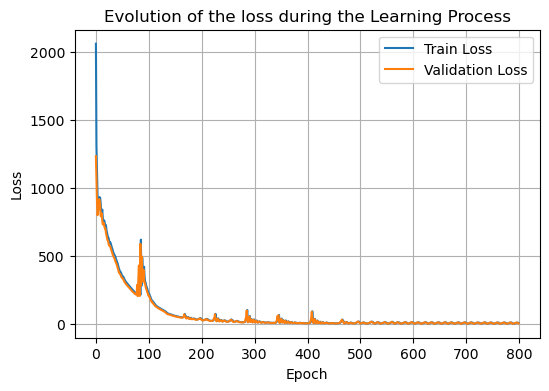

In [179]:
def loss_fn(S, T, v_net):
    v, dv_dt, dv_dS, d2v_dS2 = compute_derivatives(v_net, S, T)

    A_v = r * S * dv_dS + 0.5 * sigma ** 2 * S ** 2 * d2v_dS2

    loss_v = torch.mean((dv_dt + A_v - r * v)** 2)
    K= portfolio2.trades[0].K
    
    terminal_condition_v = call_terminal_condition(S,K)  # x_0 = S


  
    loss_terminal_v = torch.mean(((v_net(torch.cat([torch.tensor([[T_max]] * S.shape[0]).to(device), S], dim=-1))-terminal_condition_v) ** 2))

    return loss_v  + loss_terminal_v

T = torch.linspace(0.01, T_max, num_t_points).to(device)
S = torch.linspace(S_min, S_max, num_s_points).to(device)
T_grid, S_grid = torch.meshgrid(T, S, indexing='ij')
T_flat = T_grid.flatten().unsqueeze(1)  # Column Vector
S_flat = S_grid.flatten().unsqueeze(1)  # Column Vector

indices = torch.randperm(T_flat.size(0))
train_indices = indices[:int(0.8 * len(indices))]
val_indices = indices[int(0.8 * len(indices)):]

T_train, S_train = T_flat[train_indices], S_flat[train_indices]
T_val, S_val = T_flat[val_indices], S_flat[val_indices]

optimizer = optim.Adam(list(v_net.parameters()), lr=learning_rate)

train_losses = []
val_losses = []

from tqdm.notebook import tqdm

for epoch in tqdm(range(epochs), desc="Training Progress"):
    optimizer.zero_grad()
    loss_train = loss_fn(S_train, T_train, v_net)
    loss_train.backward()
    optimizer.step()

    loss_val = loss_fn(S_val, T_val, v_net)

    train_losses.append(loss_train.item())
    val_losses.append(loss_val.item())

    if epoch % 100 == 0 or epoch == epochs - 1:
        tqdm.write(f"Epoch {epoch}, Train Loss: {loss_train.item():.4f}, Val Loss: {loss_val.item():.4f}")


plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Evolution of the loss during the Learning Process")
plt.legend()
plt.grid()
plt.show()


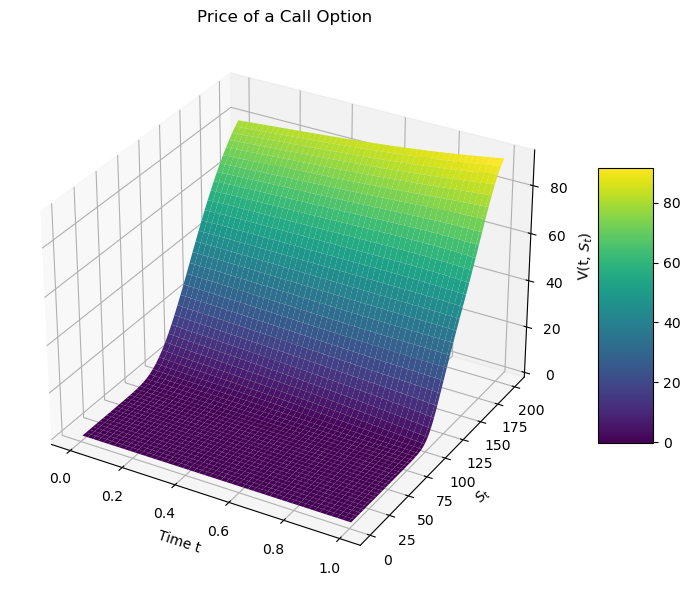

In [180]:
v_net.eval()

T_values = np.linspace(0, T_max, num_t_points)
S_values = np.linspace(0, S_max, num_s_points)
T_grid, S_grid = np.meshgrid(T_values, S_values)
points = torch.tensor(np.stack([T_grid.ravel(), S_grid.ravel()], axis=1), dtype=torch.float32).to(device)

with torch.no_grad():
    v_pred = v_net(points).cpu().numpy().reshape(T_grid.shape)

fig = plt.figure(figsize=(8,6))


ax = fig.add_subplot(1, 1,1, projection='3d')
surf = ax.plot_surface(T_grid[1:], S_grid[1:], v_pred[1:], cmap='viridis')
ax.set_xlabel('Time t')
ax.set_ylabel('$S_t$')
ax.set_zlabel(' V(t, $S_t$)')
ax.set_title('Price of a Call Option')
fig.colorbar(surf, shrink=0.5, aspect=5)



plt.tight_layout()
plt.show()

<h4> A CVA Surface : </h4> 

It can be show that the **Credit Valuation Adjustment** (CVA) in a default intensity model is solution to the following PDE :

$$
\begin{align}\label{eq : PDE CVA}
    \partial_t \phi(t,x) + \mathcal{L}\phi(t,x) - (r+ \lambda^C)\phi(t,x) + (1-R^c)(V_t)^+\lambda^C &= 0, \quad (t,x) \in [0,T( \times \mathbb{R}_*^+ \\
    \phi(T,x) &= 0, \quad x \in \mathbb{R}_{*}^+ \notag 
\end{align}
$$
where :


- $\lambda^C$ is the default intensity of the counterparty.
- $R^C$ is the recovery rate in case of default of the counterparty.
- $(V_t)^+$ is the value of the exposure of the portfolio / derivative involved between both counterparties.

In our numerical experiments, we will take the portfolio to be a standard call option with same characterics as before but with $K=110$. Moreover, we will assume $R^C=0$ and show the results for 2 different values of $\lambda^C$.
    

Training Progress:   0%|          | 0/800 [00:00<?, ?it/s]

C:\Users\samym\AppData\Local\Temp\ipykernel_16052\3788776897.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.log(St/self.K) + (r + 0.5 * sigma**2) * torch.tensor(self.T-t)) / (sigma * torch.sqrt(torch.tensor(self.T-t)))
C:\Users\samym\AppData\Local\Temp\ipykernel_16052\3788776897.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.d_plus(St, t) - sigma * torch.sqrt(torch.tensor(self.T-t))
C:\Users\samym\AppData\Local\Temp\ipykernel_16052\3788776897.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return

Epoch 0, Train Loss: 0.8271, Val Loss: 18.0514
Epoch 100, Train Loss: 0.3957, Val Loss: 0.3291
Epoch 200, Train Loss: 0.2895, Val Loss: 0.3653
Epoch 300, Train Loss: 0.0834, Val Loss: 0.0966
Epoch 400, Train Loss: 0.0308, Val Loss: 0.0682
Epoch 500, Train Loss: 0.0404, Val Loss: 0.0642
Epoch 600, Train Loss: 0.0518, Val Loss: 0.0203
Epoch 700, Train Loss: 0.1889, Val Loss: 0.1232
Epoch 799, Train Loss: 0.0743, Val Loss: 0.0730


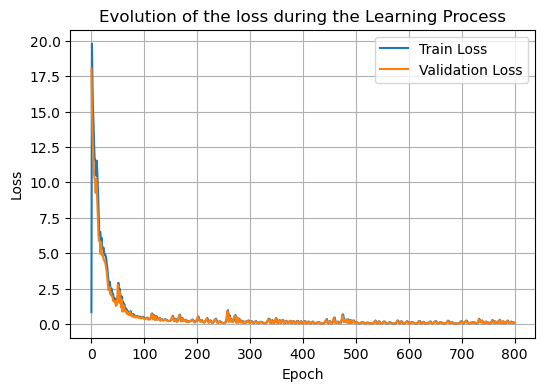

In [198]:
lambdaC=0.1 # Default Intensity 0.1 or 0.4
R=0 # Recovery Rate
def loss_fn(S, T, v_net):
    v, dv_dt, dv_dS, d2v_dS2 = compute_derivatives(v_net, S, T)

    A_v = r * S * dv_dS + 0.5 * sigma ** 2 * S ** 2 * d2v_dS2

    prix_bs = portfolio.trades[0].price(S, T)

    loss_v = torch.mean((dv_dt + A_v + (1-R)*lambdaC*prix_bs - (r+lambdaC )* v)** 2) # CVA
    

    loss_terminal_v = torch.mean((v_net(torch.cat([torch.tensor([[T_max]] * S.shape[0]).to(device), S], dim=-1)) ** 2))

    return loss_v  + loss_terminal_v

T = torch.linspace(0.01, T_max, num_t_points).to(device)
S = torch.linspace(S_min, S_max, num_s_points).to(device)
T_grid, S_grid = torch.meshgrid(T, S, indexing='ij')
T_flat = T_grid.flatten().unsqueeze(1)  
S_flat = S_grid.flatten().unsqueeze(1)  

indices = torch.randperm(T_flat.size(0))
train_indices = indices[:int(0.8 * len(indices))]
val_indices = indices[int(0.8 * len(indices)):]

T_train, S_train = T_flat[train_indices], S_flat[train_indices]
T_val, S_val = T_flat[val_indices], S_flat[val_indices]

optimizer = optim.Adam(list(v_net.parameters()), lr=learning_rate)

train_losses = []
val_losses = []

from tqdm.notebook import tqdm

for epoch in tqdm(range(epochs), desc="Training Progress"):
    optimizer.zero_grad()
    loss_train = loss_fn(S_train, T_train, v_net)
    loss_train.backward()
    optimizer.step()

    loss_val = loss_fn(S_val, T_val, v_net)

    train_losses.append(loss_train.item())
    val_losses.append(loss_val.item())

    if epoch % 100 == 0 or epoch == epochs - 1:
        tqdm.write(f"Epoch {epoch}, Train Loss: {loss_train.item():.4f}, Val Loss: {loss_val.item():.4f}")


plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Evolution of the loss during the Learning Process")
plt.legend()
plt.grid()
plt.savefig("images/CVACallPricelambda0.png")
plt.show()


<h4> Case $\lambda^C = 0.4$ : </h4> 

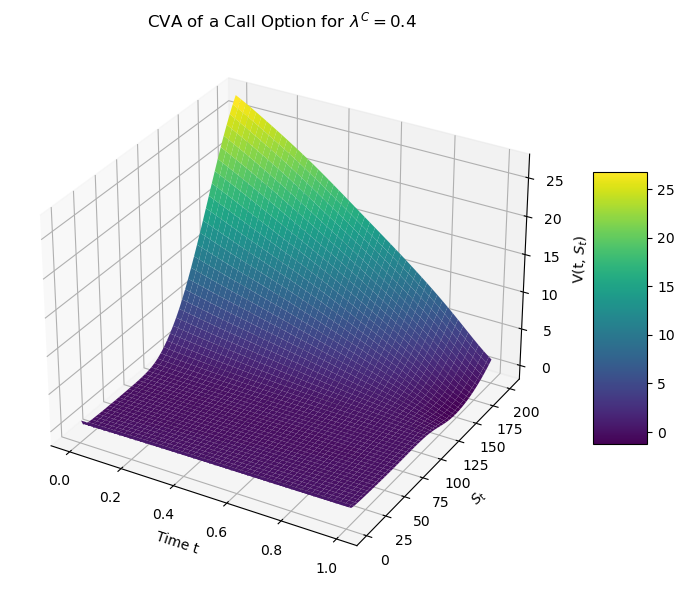

In [178]:
import numpy as np
import matplotlib.pyplot as plt


v_net.eval()

T_values = np.linspace(0, T_max, num_t_points)
S_values = np.linspace(0, S_max, num_s_points)
T_grid, S_grid = np.meshgrid(T_values, S_values)
points = torch.tensor(np.stack([T_grid.ravel(), S_grid.ravel()], axis=1), dtype=torch.float32).to(device)

with torch.no_grad():
    v_pred = v_net(points).cpu().numpy().reshape(T_grid.shape)

fig = plt.figure(figsize=(8,6))


ax = fig.add_subplot(1, 1,1, projection='3d')
surf = ax.plot_surface(T_grid[1:], S_grid[1:], v_pred[1:], cmap='viridis')
ax.set_xlabel('Time t')
ax.set_ylabel('$S_t$')
ax.set_zlabel(' V(t, $S_t$)')
ax.set_title("CVA of a Call Option for $\lambda^C = 0.4$")
fig.colorbar(surf, shrink=0.5, aspect=5)

             
             
plt.tight_layout()
plt.show()

<h4> Case $\lambda^C = 0.1$ : </h4> 

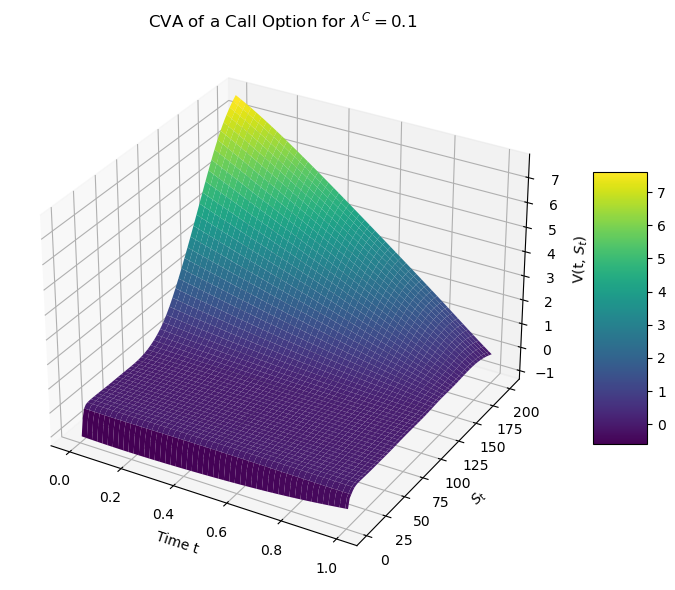

In [199]:
import numpy as np
import matplotlib.pyplot as plt


v_net.eval()

T_values = np.linspace(0, T_max, num_t_points)
S_values = np.linspace(0, S_max, num_s_points)
T_grid, S_grid = np.meshgrid(T_values, S_values)
points = torch.tensor(np.stack([T_grid.ravel(), S_grid.ravel()], axis=1), dtype=torch.float32).to(device)

with torch.no_grad():
    v_pred = v_net(points).cpu().numpy().reshape(T_grid.shape)

fig = plt.figure(figsize=(8,6))


ax = fig.add_subplot(1, 1,1, projection='3d')
surf = ax.plot_surface(T_grid[1:], S_grid[1:], v_pred[1:], cmap='viridis')
ax.set_xlabel('Time t')
ax.set_ylabel('$S_t$')
ax.set_zlabel(' V(t, $S_t$)')
ax.set_title("CVA of a Call Option for $\lambda^C = 0.1$")
fig.colorbar(surf, shrink=0.5, aspect=5)

             
             
plt.tight_layout()
plt.show()

<h4> FVA and KVA coupled PDE :  </h4>

In a toy model, we can show that $KVA$ and $FVA$ are  solution to the following coupled systems of PDE associated respectively with $w$ and $v$ :

$$
\begin{align}
\frac{\partial{v}}{\partial{t}}+\mathcal{L}v+ \lambda(u_{bs}-v-\alpha f \sigma S |\Delta_{bs} -\frac{\partial{v}}{\partial{S}}|^{+}-rv=0 \quad (t,x) \in ]0,T[\times  \mathbb{R}_{*}^+ \tag{10} \\
\frac{\partial{w}}{\partial{t}}+ \mathcal{L}w+ \alpha h f \sigma S |\Delta_{bs}-\frac{\partial{v}}{\partial{S}}|-(r+h)w=0, \quad  (t,x) \in ]0,T[ \times  \mathbb{R}_{*}^+ \tag{11} \\
v(T,S)=w(T,S)=0  \quad x \in \mathbb{R}_{*}^+ \notag 
\end{align}
$$
where 

- $h$ represents a dividend rate
- $\alpha$ represents a mishedge parameter
- $\lambda$ is a funding rate 
- $f$ is a quantile level
- $u_{bs}$ and $\Delta_{bs}$ represent the call and delta price of a single call option of same characteristics as before.

In this couple PDE systems, we parametrize two neural networks $\mathcal{U}_1(\theta_1)$ and $\mathcal{U}_2(\theta_2)$ and we solve $\underset{\theta = (\theta_1,\theta_2)}{\text{ inf }} \mathbb{L}(\mathcal{U}(\theta))$ where $\mathbb{L}$ represents the operator associated  to system of PDE (10) and (11).  For the numerical experiments, we took $\alpha = 0.3$,  $\lambda=0.02$, $f=1.2$ and $h=0.1$.


Training Progress:   0%|          | 0/800 [00:00<?, ?it/s]

C:\Users\samym\AppData\Local\Temp\ipykernel_16052\3788776897.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.log(St/self.K) + (r + 0.5 * sigma**2) * torch.tensor(self.T-t)) / (sigma * torch.sqrt(torch.tensor(self.T-t)))
C:\Users\samym\AppData\Local\Temp\ipykernel_16052\3788776897.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.d_plus(St, t) - sigma * torch.sqrt(torch.tensor(self.T-t))
C:\Users\samym\AppData\Local\Temp\ipykernel_16052\3788776897.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return

Epoch 0, Train Loss: 1.0160, Val Loss: 25.2447
Epoch 100, Train Loss: 0.4713, Val Loss: 0.4349
Epoch 200, Train Loss: 0.0731, Val Loss: 0.0660
Epoch 300, Train Loss: 0.0381, Val Loss: 0.0374
Epoch 400, Train Loss: 0.0361, Val Loss: 0.0244
Epoch 500, Train Loss: 0.0168, Val Loss: 0.0158
Epoch 600, Train Loss: 0.0141, Val Loss: 0.0169
Epoch 700, Train Loss: 0.0181, Val Loss: 0.0169
Epoch 799, Train Loss: 0.0150, Val Loss: 0.0147


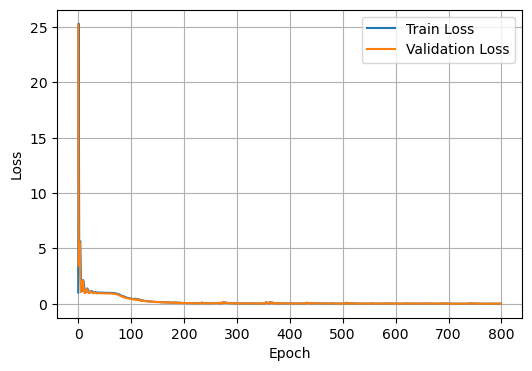

In [190]:
batch_size = 1000  
epochs = 800
alpha = 0.3
hparam = 0.1
f = 1.2
lambd = 0.02



v_net = Net().to(device)
w_net = Net().to(device)

# Fonction de perte
def loss_fn(S, T, v_net, w_net):
    v, dv_dt, dv_dS, d2v_dS2 = compute_derivatives(v_net, S, T)
    w, dw_dt, dw_dS, d2w_dS2 = compute_derivatives(w_net, S, T)

    A_v = r * S * dv_dS + 0.5 * sigma ** 2 * S ** 2 * d2v_dS2
    A_w = r * S * dw_dS + 0.5 * sigma ** 2 * S ** 2 * d2w_dS2

    prix_bs = portfolio.trades[0].price(S, T)
    delta_bs = portfolio.trades[0].delta(S, T)

    # Defining losses for $v$ and $w$
    loss_v = torch.mean((dv_dt + A_v + lambd * torch.abs((torch.max(alpha * f * sigma * S * torch.abs(dv_dS - delta_bs), w) + v - prix_bs).clamp(max=0)) - r * v) ** 2)
    loss_w = torch.mean((dw_dt + A_w + hparam * torch.max(alpha * f * sigma * S * torch.abs(dv_dS - delta_bs), w) - (r + hparam) * w) ** 2)

    # Terminal conditions
    loss_terminal_v = torch.mean((v_net(torch.cat([torch.tensor([[T_max]] * S.shape[0]).to(device), S], dim=-1)) ** 2))
    loss_terminal_w = torch.mean((w_net(torch.cat([torch.tensor([[T_max]] * S.shape[0]).to(device), S], dim=-1)) ** 2))

    return loss_v + loss_w + loss_terminal_v + loss_terminal_w

T = torch.linspace(0, T_max, num_t_points).to(device)
S = torch.linspace(S_min, S_max, num_s_points).to(device)
T_grid, S_grid = torch.meshgrid(T, S, indexing='ij')
T_flat = T_grid.flatten().unsqueeze(1)  
S_flat = S_grid.flatten().unsqueeze(1)  

indices = torch.randperm(T_flat.size(0))
train_indices = indices[:int(0.8 * len(indices))]
val_indices = indices[int(0.8 * len(indices)):]

T_train, S_train = T_flat[train_indices], S_flat[train_indices]
T_val, S_val = T_flat[val_indices], S_flat[val_indices]

optimizer = optim.Adam(list(v_net.parameters()) + list(w_net.parameters()), lr=learning_rate)

train_losses = []
val_losses = []

from tqdm.notebook import tqdm

for epoch in tqdm(range(epochs), desc="Training Progress"):
    optimizer.zero_grad()
    loss_train = loss_fn(S_train, T_train, v_net, w_net)
    loss_train.backward()
    optimizer.step()

    
    loss_val = loss_fn(S_val, T_val, v_net, w_net)

    train_losses.append(loss_train.item())
    val_losses.append(loss_val.item())

    if epoch % 100 == 0 or epoch == epochs - 1:
        tqdm.write(f"Epoch {epoch}, Train Loss: {loss_train.item():.4f}, Val Loss: {loss_val.item():.4f}")

plt.figure(figsize=(6,4))
plt.grid()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("images/TrainingValLossesFVAKVA.png")
plt.show()


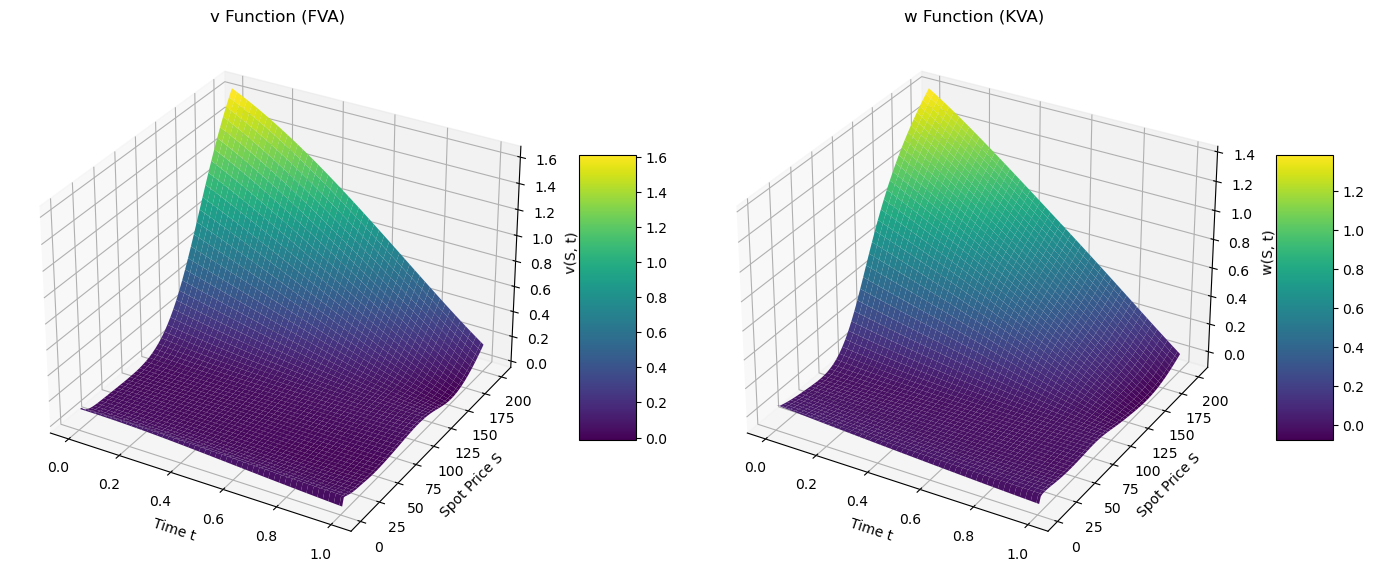

In [173]:
v_net.eval()
w_net.eval()

T_values = np.linspace(0, T_max, num_t_points)
S_values = np.linspace(0, S_max, num_s_points)
T_grid, S_grid = np.meshgrid(T_values, S_values)
points = torch.tensor(np.stack([T_grid.ravel(), S_grid.ravel()], axis=1), dtype=torch.float32).to(device)

with torch.no_grad():
    v_pred = v_net(points).cpu().numpy().reshape(T_grid.shape)
    w_pred = w_net(points).cpu().numpy().reshape(T_grid.shape)

fig = plt.figure(figsize=(14, 6))

ax = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax.plot_surface(T_grid[1:], S_grid[1:], v_pred[1:], cmap='viridis')
ax.set_xlabel('Time t')
ax.set_ylabel('Spot Price S')
ax.set_zlabel('v(S, t)')
ax.set_title('v Function (FVA)')
fig.colorbar(surf, shrink=0.5, aspect=5)


ax = fig.add_subplot(1, 2, 2, projection='3d')
surf = ax.plot_surface(T_grid[1:], S_grid[1:], w_pred[1:], cmap='viridis')
ax.set_xlabel('Time t')
ax.set_ylabel('Spot Price S')
ax.set_zlabel('w(S, t)')
ax.set_title('w Function (KVA)')
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()


<a id=deepBSDE-Applications></a>

<h2> <center> Some applications of Deep BSDE Algorithm : </h2> </center>


We are going to present some simple applications of the Deep BSDE Solver for solving PDEs with the following form : 

$\begin{align}\tag{1}
\partial_t v + \mathcal{L}v + f(x,v,\nabla_x v) &= 0, \quad (t,x) \in [0,T) \times  \mathbb{R}^d \\
v(T,x) &= g(x), \quad x \in \mathbb{R}^d
\end{align}$

From this PDE, we can consider a probability space ($\Omega,\mathcal{F},\mathbb{P})$ which supports a brownian motion $W=(W_t)_{t \geq 0}$ with his natural filtration $\mathbb{F}=(\mathcal{F}_t)_{t \geq 0}$ and we can introduce the forward process $X=(X_t)_{t \geq 0}$ associated to the operator $\mathcal{L}$. Assuming this process known, we can consider the following pair of processes $(Y,Z)$ solving the following BSDE :

$$\begin{align}\tag{2}
- dY_t &= f(t,X_t,Y_t,Z_t) - Z_t dW_t, \quad 0 \leq t \leq T \\
Y_T &= g(X_T)
\end{align}$$

Applying Itô Formula to the process $v(t,X_t)$ with $v$ solving the PDE , we can see that :

$$\begin{align}
v(T,X_T) &= v(t,X_t)  + \int_{t}^{T} (\partial_t v+ \mathcal{L}[v])(s,X_s)ds  + \int_{t}^{T}  \nabla_x v(s,X_s)^{\top}dW_s \\
&=v(t,X_t) - \int_{t}^{T} f(s,v(s,X_s), \nabla_x v(s,X_s)) ds + \int_{t}^{T} \nabla_x v(s,X_s)^{\top} dW_s
\end{align}$$

Differentiating this equation, we see that the process $v(t,X_t)$ solves the following the following BSDE :

$$\begin{align}
- dv(t,X_t) &= f(t,v(t,X_t),\nabla_x v(t,X_t))- \nabla_x v(t,X_t)^{\top} dW_t \notag \\
v(T,X_T) &= g(X_T)
\end{align}$$

From existence and unicity of the theory of BSDE under suitable assumptions on $f$, we have the following representation for the pair $(Y,Z)$ :

$$\begin{align}\tag{3} 
 Y_t &= v(t,X_t) \quad dt \otimes d\mathbb{P} \quad   a.e  \\
 Z_t &= \nabla_x v(t,X_t) \quad dt \otimes d\mathbb{P} \quad   a.e
\end{align}$$



<a id=deepBSDE-reminder></a>

<h3>A reminder of the Deep BSDE Algorithm : </h3>


The Deep BSDE Algorithm is based on the representation of the equation (4) as it means that founding $v$ is equivalent to founding $Y$. Therefore, going back to equation (2), we can look for discretization of $Y$ and approximating $v(t_i,X_{t_i})$ as $Y_{t_i}$. However, note that the scheme is backward in time which would need to approximation conditional expectations at each time. Therefore, the idea of the algorithm is to treat the process $Y$ as a forward process for an unknown $y_0$ and for process $Z$ . We can then define the following loss $\mathcal{L}$ for a given $y_0 \in \mathbb{R}$ and $\mathcal{Z}$ a squared adapted integrable process as : 

$$
\begin{align}
\mathcal{L}(y_0,\mathcal{Z}) = \mathbb{E}[|Y_T^{y_0,\mathcal{Z}}- g(X_T)|^2]
\end{align}
$$
where we set :


$$
\begin{align}
Y_t^{y_0,\mathcal{Z}} = y_0 - \int_{0}^{t} f(X_s,Y_s^{y_0,\mathcal{Z}},\mathcal{Z}_s)) ds  + \int_{0}^{t} \mathcal{Z}_s dW_s 
\end{align}
$$
Therefore, as $y_0$ and $\mathcal{Z}$ are unknown parameters, they can be learnt through neural networks assuming that $\mathcal{Z} = \mathcal{Z}(s,X_s)$. The idea is then to learn through a neural network the mapping $(t,x) \to \mathcal{Z}(t,x)$ using a neural network $\mathcal{Z}^{\theta}$ and to put $y_0$ as a trainable parameter of this neural network which will be learnt during the training process.


Therefore, the idea is to minimize the following loss error :

$$\begin{align}\tag{6}
L(\theta) = \mathbb{E}[|Y_T^{\theta} - g(X_T)|^2]
\end{align}$$

where we have :

- $Y_t^{\theta} = y_0^{\theta} - \int_{0}^{t} f(X_s,Y_s^{\theta},\mathcal{Z}^{\theta}(s, X_{s})) ds + \int_{0}^{t} \mathcal{Z}^{\theta}(s,X_s)^{\top}\sigma(s,X_s) dW_s \$



<h4> In practice : </h4>


- Of course, for the numerical experiments, we will discretize using an Euler Scheme on a grid $0=t_0 < t_1 < \ldots < t_N = T$ with time step $\Delta t$ : starting from $Y_0^{\theta} = y_0^{\theta}$, we have :

\begin{align}
Y_{t_{i+1}}^{\theta} = Y_{t_{i}}^{\theta} - f \big(X_{t_i},Y_{t_i}^{\theta},\mathcal{Z}_{\theta}(t_i, X_{t_i})^{\top} \big) \Delta t + \sigma(t_i,X_{t_i}) \Delta W_{t_i}, \quad i=0,\ldots,n-1
\end{align}


<h4> Final Output : </h4>

For an optimal $\theta^*$ which solves the optimization problem (6), we have :  
- $Y_0 = v(0,.) \approx Y_0^{\theta^*} = y_0^{\theta^*}$ and more generally $Y_{t_i} = v(t_i,.) \approx Y_{t_i}^{\theta^*}$ for $i =0, \ldots,n$
- $Z_{t_i} = \partial_x v(t_i,.) \approx \mathcal{Z}_{\theta^*}(t_i, X_{t_i})$

<a id=deepBSDE-results></a>

<h3> Some Numerical Results : </h3> 

In [5]:
class fbsde():
    def __init__(self, x_0, b, sigma, f, g, T, dim_x,dim_y,dim_d):
        self.x_0 = x_0.to(device)
        self.b = b
        self.sigma = sigma
        self.f = f
        self.g = g
        self.T = T
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.dim_d = dim_d


class Model(nn.Module):
    def __init__(self, equation, dim_h):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(equation.dim_x+1, dim_h)
        self.linear2 = nn.Linear(dim_h, dim_h)
        self.linear3 = nn.Linear(dim_h, equation.dim_y*equation.dim_d)
        self.y_0 = nn.Parameter(torch.rand(equation.dim_y, device=device))
        
        self.equation= equation


    def forward(self,batch_size, N):
        def phi(x):
            x = F.relu(self.linear1(x))
            x = F.relu(self.linear2(x))
            return self.linear3(x).reshape(-1, self.equation.dim_y, self.equation.dim_d)

        delta_t = self.equation.T / N
        
        W = torch.randn(batch_size, self.equation.dim_d, N, device=device) * np.sqrt(delta_t)
       
        x = self.equation.x_0+torch.zeros(W.size()[0],self.equation.dim_x,device=device)
        y = self.y_0+torch.zeros(W.size()[0],self.equation.dim_y,device=device)
        for i in range(N):
            u = torch.cat((x, torch.ones(x.size()[0], 1,device=device)*delta_t*i), 1)
            z = phi(u)
            w = W[:, :, i].reshape(-1, self.equation.dim_d, 1)
            x = x+self.equation.b(delta_t*i, x)*delta_t+torch.matmul( self.equation.sigma(delta_t*i, x), w).reshape(-1, self.equation.dim_x)
            y = y-self.equation.f(delta_t*i, x, y, z)*delta_t + torch.matmul(z, w).reshape(-1, self.equation.dim_y)
        return x, y


class BSDEsolver():
    def __init__(self, equation, dim_h):
        self.model = Model(equation,dim_h).to(device)
        self.equation = equation

    def train(self, batch_size, N, itr):
        criterion = torch.nn.MSELoss().to(device)

        optimizer = torch.optim.Adam(self.model.parameters(),lr=1e-2)

        loss_data, y0_data = [], []

        for i in tqdm(range(itr)):
            x, y = self.model(batch_size,N)
            loss = criterion(self.equation.g(x), y)
            loss_data.append(float(loss))
            y0_data.append(float(self.model.y_0))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        #if log:
        #    np.save('loss_data', loss_data)
        #    np.save('y0_data', y0_data)
        return loss_data,y0_data

<h3> <center> Some experiments in the $B-S$ model : </center> </h3> 

We now assume a $B-S$ model for the numerical experiments with the stock price dynamics $S=(S_t)_{t \geq 0}$ given by :


$$
\begin{align}
dS_t = S_t ( r dt + \sigma dW_t), \quad S_0 \in  (\mathbb{R}^{+}_{*})^d
\end{align}
$$

Under the option pricing theory in the $B-S$, for an european option with price at time $t$ denoted by $C(t,S_t)$ we know that we have the following PDE for the option price $C$ defined on $[0,T] \times (\mathbb{R}^{+}_{*})^d$ as :
$$
\begin{align}
\partial_t C + \mathcal{L}C - rC &= 0 \quad (t,x) \in [0,T) \times (\mathbb{R}^{+}_{*})^d \\
C(T,x) &= g(x) \quad x \in (\mathbb{R}^{+}_{*})^d
\end{align}
$$

where the infinitemisal generator is given by :

$$
\begin{align}
\mathcal{L}v(t,x) = b(t,x)^{\top} D_x v (t,x) \frac{1}{2} \sigma(t,x) \sigma(t,x)^{\top} D^2_x v(t,x)
\end{align}
$$
Therefore, in this setting, the equivalent functions $f$ and $g$ are given by :

- $f(t,x,y,z) = - r * y$
- $g(x)$ : Option Payoff

In [73]:
r, sigma_value = 0.05, 0.2 

dim_x, dim_y, dim_d, dim_h, N, itr, batch_size, K =100, 1, 100, dim_x+10, 20, 2000, 1000, 1

x_0, T = torch.ones(dim_x), 1

def b(t, x):
    return r* x.reshape(batch_size, dim_x)


def sigma(t, x):
    sigma_matrix = torch.tensor(sigma_value * np.eye(dim_x),dtype=torch.float32)
    C=torch.matmul(sigma_matrix,x.T).reshape(batch_size,dim_x)
    matrix = torch.diag_embed(C) # Crée une matrice diagonale avec une liste de vecteurs
    return matrix

    #return torch.sqrt(torch.abs(x)).reshape(batch_size, dim_x, dim_d)


def f(t, x, y, z):
    return (-r*y).reshape(batch_size,dim_y)
    #return (-y*x).reshape(batch_size, dim_y)


def g(x):
    #return torch.where(x > K, torch.tensor(1, device=x.device, dtype=x.dtype), torch.tensor(0, device=x.device, dtype=x.dtype))
    #return torch.relu(torch.sum(x,dim=1)- dim_x*K).reshape(batch_size,dim_y) # Basket Call Option sur dim_x sous-jacents.
    return torch.relu(dim_x*K - torch.sum(x,dim=1)).reshape(batch_size,dim_y) # Basket Put Option sur dim_x sous-jacents.
    #print((torch.sum(x,dim=1)- dim_x*K).reshape(batch_size,dim_y))
    #return (torch.sum(x,dim=1)- dim_x * K).reshape(batch_size,dim_y) #Basket Forward Option sur dim_x sous-jacents 


equation = fbsde(x_0, b, sigma, f, g, T,dim_x, dim_y, dim_d)

bsde_solver = BSDEsolver(equation, dim_h)
loss_data,y0_data = bsde_solver.train(batch_size, N, itr)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [13:08<00:00,  2.54it/s]


<h3> A numerical result on a  Basket Call Option under $B-S$ model  in low and high dimension $d$ :  </h3>

- $g(x) = (\sum_{i=1}^{d} x_i- d K)^+$

<h4> Numerical results for $d=1$ : </h4>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

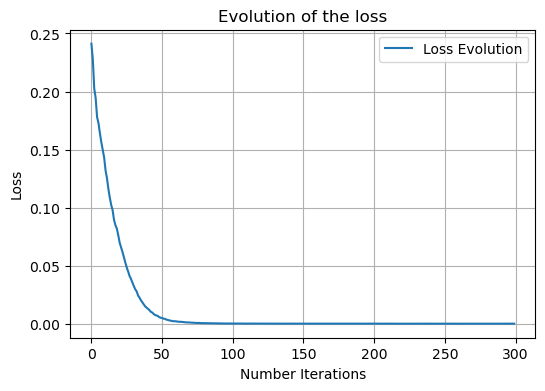

In [15]:
plt.figure(figsize=(6, 4))  # Par exemple, 8 pouces x 6 pouces
plt.plot(loss_data,label="Loss Evolution")
plt.grid()
plt.xlabel("Number Iterations")
plt.ylabel("Loss")
plt.title("Evolution of the loss")
plt.legend()
plt.savefig("images/LossCallPriced=1.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

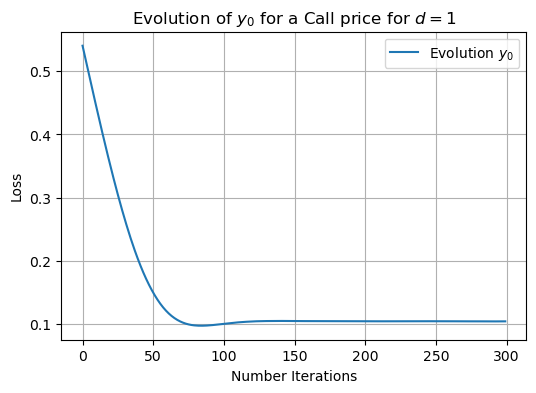

In [23]:
plt.figure(figsize=(6, 4))  
plt.plot(y0_data,label="Evolution $y_0$")
plt.grid()
plt.xlabel("Number Iterations")
plt.ylabel("Loss")
plt.title("Evolution of $y_0$ for a Call price for $d=1$")
plt.legend()
plt.savefig("images/y0CallPriced=1.png")

In [21]:
import math
from scipy.stats import norm

def black_scholes_call(S, K, T, r, sigma):
    d1 = (math.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    return call_price

S = 1  

call_price = black_scholes_call(S, K, T, r, sigma_value)


In [22]:
print("Approximate value : " + str(np.round(y0_data[-1],4)))
print("True Value " + str(np.round(call_price,4)))

Approximate value : 0.1043
True Value 0.1045


<h4> Numerical results for $d=100$ : </h4>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

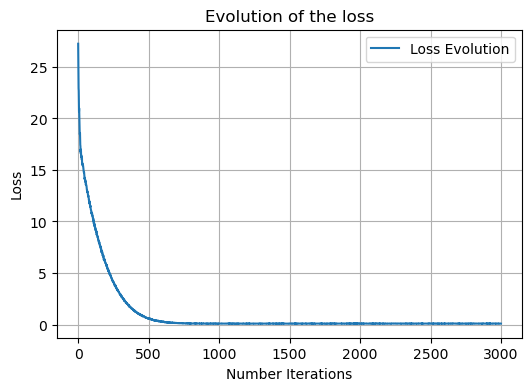

In [25]:
plt.figure(figsize=(6, 4))
plt.plot(loss_data,label="Loss Evolution")
plt.grid()
plt.xlabel("Number Iterations")
plt.ylabel("Loss")
plt.title("Evolution of the loss")
plt.legend()
plt.savefig("images/LossCallPriced=100.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

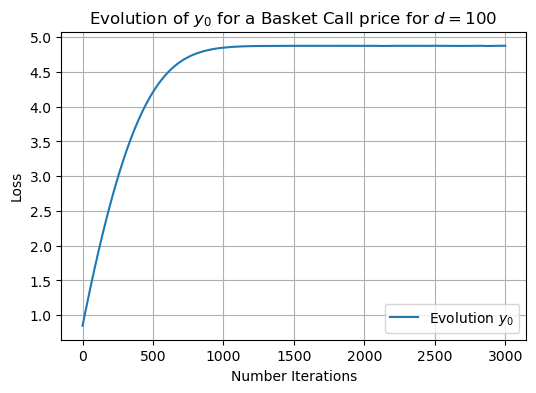

In [26]:
plt.figure(figsize=(6, 4))  # Par exemple, 8 pouces x 6 pouces
plt.plot(y0_data,label="Evolution $y_0$")
plt.grid()
plt.xlabel("Number Iterations")
plt.ylabel("Loss")
plt.title("Evolution of $y_0$ for a Basket Call price for $d=100$ ")
plt.legend()
plt.savefig("images/y0CallPriced=100.png")

In [27]:
print("Approximate value : " + str(np.round(y0_data[-1],4)))

Approximate value : 4.8771


<h3> A numerical result on a Price Put under $B-S$ model in low and high dimension $d$:  </h3>


- $g(x) = (d K- \sum_{i=1}^{d} x_i)^+$

<h4> Numerical Result for $d=1$ :  </h4>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

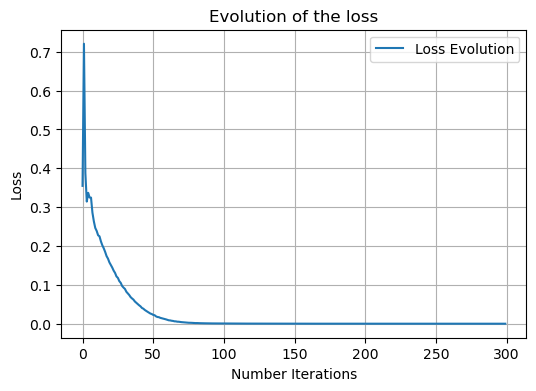

In [32]:
plt.figure(figsize=(6, 4))  # Par exemple, 8 pouces x 6 pouces
plt.plot(loss_data,label="Loss Evolution")
plt.grid()
plt.xlabel("Number Iterations")
plt.ylabel("Loss")
plt.title("Evolution of the loss")
plt.legend()
plt.savefig("images/LossPutPriced=1.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

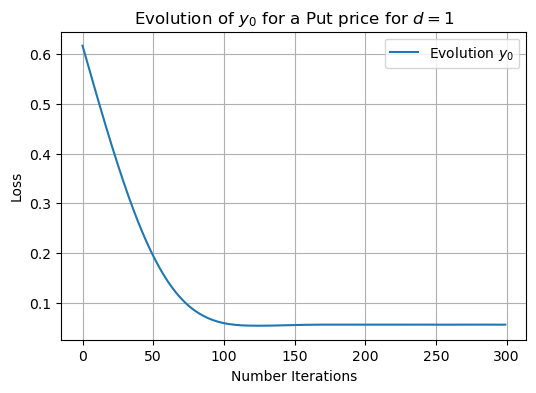

In [33]:
plt.figure(figsize=(6, 4))  # Par exemple, 8 pouces x 6 pouces
plt.plot(y0_data,label="Evolution $y_0$")
plt.grid()
plt.xlabel("Number Iterations")
plt.ylabel("Loss")
plt.title("Evolution of $y_0$ for a Put price for $d=1$")
plt.legend()
plt.savefig("images/y0PutPriced=1.png")

In [35]:
def black_scholes_put(S, K, T, r, sigma):
    """
    Calcule le prix d'un put européen selon le modèle de Black-Scholes.
    
    :param S: Prix actuel de l'actif sous-jacent
    :param K: Prix d'exercice de l'option
    :param T: Temps jusqu'à l'échéance (en années)
    :param r: Taux d'intérêt sans risque (en décimal)
    :param sigma: Volatilité de l'actif sous-jacent (en décimal)
    :return: Prix de l'option put
    """
    d1 = (math.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    put_price = K * math.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price


S = 1  

put_price = black_scholes_put(S, K, T, r, sigma_value)


In [38]:
print("Approximate value : " + str(np.round(y0_data[-1],5)))
print("True Value : " + str(np.round(put_price,5)))

Approximate value : 0.05568
True Value : 0.05574


<h4> Numerical Result for $d=100$ :  </h4>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

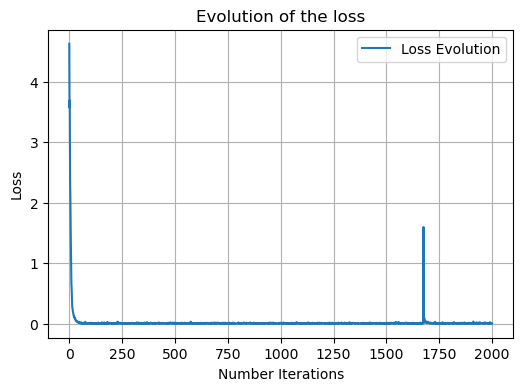

In [74]:
plt.figure(figsize=(6, 4))  # Par exemple, 8 pouces x 6 pouces
plt.plot(loss_data,label="Loss Evolution")
plt.grid()
plt.xlabel("Number Iterations")
plt.ylabel("Loss")
plt.title("Evolution of the loss")
plt.legend()
plt.savefig("images/LossPutPriced=100.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

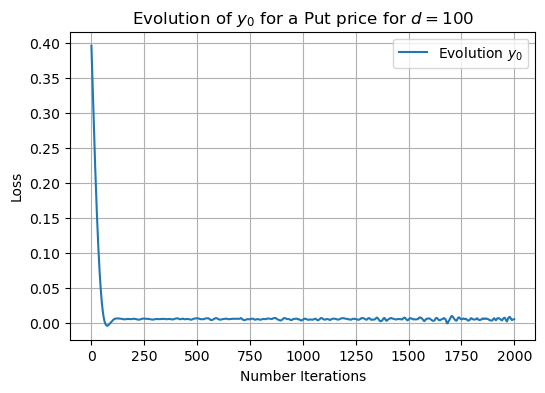

In [75]:
plt.figure(figsize=(6, 4))  # Par exemple, 8 pouces x 6 pouces
plt.plot(y0_data,label="Evolution $y_0$")
plt.grid()
plt.xlabel("Number Iterations")
plt.ylabel("Loss")
plt.title("Evolution of $y_0$ for a Put price for $d=100$")
plt.legend()
plt.savefig("images/y0PutPriced=100.png")

In [76]:
print("Approximate value : " + str(np.round(y0_data[-1],4)))

Approximate value : 0.0051


<h3> A numerical result on a Binary Call under $B-S$ model in dimension 1 : </h3> 


- $g(x) = \mathbb{1}_{x \geq K}$

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

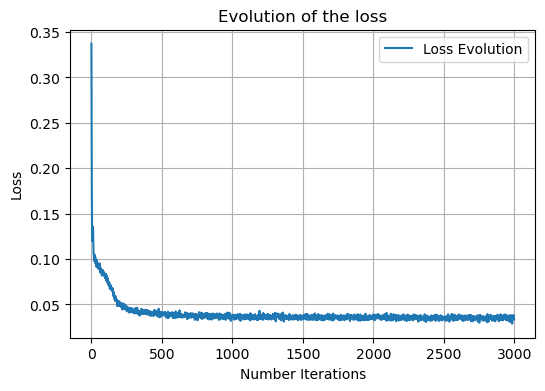

In [43]:
plt.figure(figsize=(6, 4))  # Par exemple, 8 pouces x 6 pouces
plt.plot(loss_data,label="Loss Evolution")
plt.grid()
plt.xlabel("Number Iterations")
plt.ylabel("Loss")
plt.title("Evolution of the loss")
plt.legend()
plt.savefig("images/LossBinaryOption.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

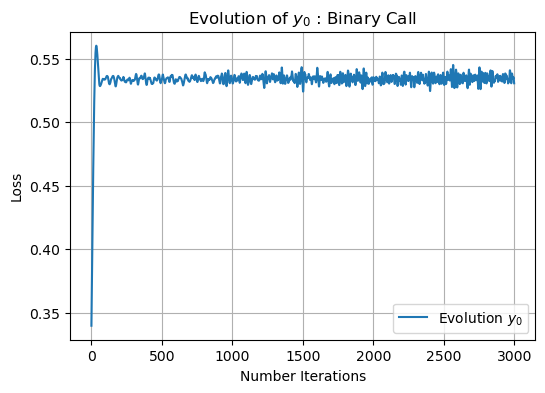

In [44]:
plt.figure(figsize=(6, 4))  # Par exemple, 8 pouces x 6 pouces
plt.plot(y0_data,label="Evolution $y_0$")
plt.grid()
plt.xlabel("Number Iterations")
plt.ylabel("Loss")
plt.title("Evolution of $y_0$ : Binary Call")
plt.legend()
plt.savefig("images/y0BinaryOption.png")

In [69]:
def black_scholes_binary(S, K, T, r, sigma):
    """
    Calcule le prix d'un put européen selon le modèle de Black-Scholes.
    
    :param S: Prix actuel de l'actif sous-jacent
    :param K: Prix d'exercice de l'option
    :param T: Temps jusqu'à l'échéance (en années)
    :param r: Taux d'intérêt sans risque (en décimal)
    :param sigma: Volatilité de l'actif sous-jacent (en décimal)
    :return: Prix de l'option put
    """
    d2= (math.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    return math.exp(-r * T) * norm.cdf(d2)

S = 1  

binary_price = black_scholes_binary(S, K, T, r, sigma_value)


In [72]:
print("Approximate value of the Binary Call price : " + str(np.round(y0_data[-1],4)))
print("Estimate value : "  + str(np.round(binary_price,4)))

Approximate value of the Binary Call price : 0.5307
Estimate value : 0.5323


<h3> <center>  Allen-Cahn PDE : </h3> </center>

The Allen-Cahn PDE is given by the following :


$$
\begin{align}
\partial_t v + \partial^2_{x} v + v - v^3 &= 0 \quad (t,x) \in [0,T(  \times \mathbb{R}^d \notag \\
v(T,x) &= \frac{1}{ 2+ \frac{2}{5} \lVert x \rVert^2} \quad x \in  \mathbb{R}^d
\end{align}
$$

In this case, we can recover the **BSDE setting** with the following forward process : 

$$
\begin{align}
dX_t = \sqrt{2}I_{d \times d} dW_t \in \mathbb{R}^d 
\end{align}
$$
and with the pair of process $(Y,Z)$ by setting :

- $f(t,x,y,z) = y - y^3$ with $y$ valued $\in \mathbb{R}$
- $g(x) = \frac{1}{ 2+ \frac{2}{5} \lVert x \rVert^2} \in \mathbb{R}$


In the numerical experiments, we will set $T=\frac{3}{10}$ with $x_0=0$ and $d=100$ and try to recover the true estimate value of the PDE with such a setting like in the article $\textit{"Deep learning-based numerical methods for high-dimensional parabolic partial differential"}$


In [7]:
sigma_value = np.sqrt(2) 


dim_x, dim_y, dim_d, dim_h, N, itr, batch_size = 100, 1, 100, 110, 20, 3000, 1000

x_0, T = torch.zeros(dim_x), 3/10

def b(t,x):
    return 0

def sigma(t, x):
    sigma_matrix = torch.tensor(sigma_value * np.eye(dim_x),dtype=torch.float32)
    return sigma_matrix
    #return torch.sqrt(torch.abs(x)).reshape(batch_size, dim_x, dim_d)


def f(t, x, y, z):
    return (y-torch.pow(y,3)).reshape(batch_size,dim_y)


def g(x):
    norm_x_squared = torch.norm(x,p=2, dim=1)**2  # Norme L2 au carré
    return (1 / (2 + (2/5) * norm_x_squared)).reshape(batch_size,dim_y)


equation = fbsde(x_0, b, sigma, f, g, T,dim_x, dim_y, dim_d)

bsde_solver = BSDEsolver(equation, dim_h)
loss_data,y0_data = bsde_solver.train(batch_size, N, itr)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [14:52<00:00,  3.36it/s]


<h4> Allen Cahn PDE plots :  </h4>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

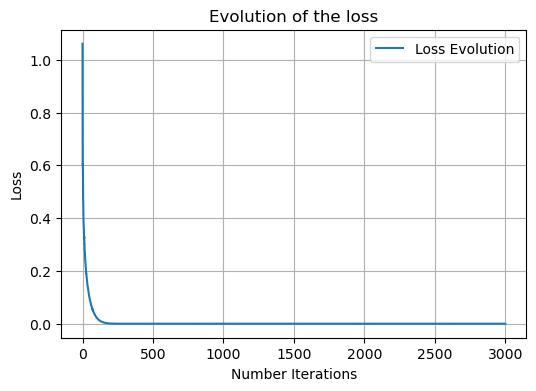

In [8]:
plt.figure(figsize=(6, 4))  # Par exemple, 8 pouces x 6 pouces

plt.plot(loss_data,label="Loss Evolution")
plt.grid()
plt.xlabel("Number Iterations")
plt.ylabel("Loss")
plt.title("Evolution of the loss")
plt.legend()
plt.savefig("images/LossAllenCahnProblem.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

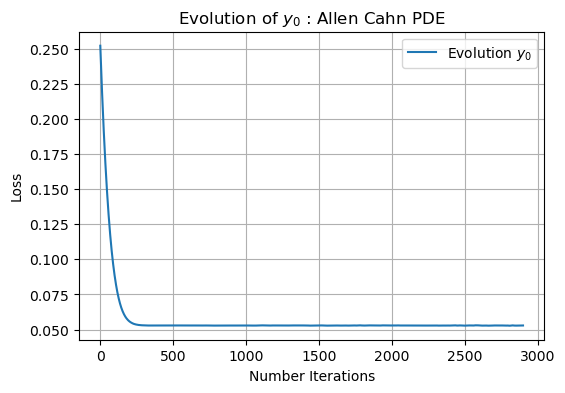

In [12]:
plt.figure(figsize=(6, 4))  # Par exemple, 8 pouces x 6 pouces
plt.plot(y0_data[100:],label="Evolution $y_0$")
plt.grid()
plt.xlabel("Number Iterations")
plt.ylabel("Loss")
plt.title("Evolution of $y_0$ : Allen Cahn PDE")
plt.legend()
plt.savefig("images/y0AllenCahnProblem.png")

In [10]:
print("Approximate value of the Allen-Cahn equation: " + str(np.round(y0_data[-1],4)))
print("Estimate true value " + str(0.052802))  # Value taken from E, Han, Jentzen : https://arxiv.org/pdf/1706.04702"


Approximate value of the Allen-Cahn equation: 0.0529
Estimate true value 0.052802


<h3> <center> An HJB control problem : </h3> </center>


We consider the following PDE which can be shown to be the PDE arising from an HJB equation in optimal control :


$$
\begin{align}
    \partial_t v +  \Delta_x v - \frac{1}{2} | \nabla_x v|^2 &= 0, \quad (t,x) \in [0,T) \times \mathbb{R}^d \notag \\
    v(T,x) &= g(x) \notag 
\end{align}
$$

In this case, we can recover the **BSDE setting**  with the following forward process : 

$$
\begin{align}
dX_t = \sqrt{2}I_{d \times d} dW_t \in \mathbb{R}^d  \notag 
\end{align}
$$
and with the pair of process $(Y,Z)$ by setting :

- $f(t,x,y,z) = - \lVert z \rVert^2$ with $z$ $\in \mathbb{R}^{1 \times d}$

For the numerical experiments, we choose $x_0=0$, $d=100$, and $g(x) = \text{ln}(\frac{1}{2}( 1+ \lVert x \rVert^2)$ with $\textit{semi-explicit form}$ given by Hopf-Cole transformation :

$$
\begin{align}
    v(0,x_0) = - \text{ln}\bigg(\mathbb{E}\Big[\text{exp}\big(-g(x_0 + \sigma W_T) \big)\Big]\bigg) \notag 
\end{align}
$$

In [ ]:
sigma_value = np.sqrt(2) 


dim_x, dim_y, dim_d, dim_h, N, itr, batch_size = 100, 1, 100, dim_x+10, 20, 5000, 1000

x_0, T = torch.zeros(dim_x), 1


def b(t,x):
    return 0

def sigma(t, x):
    sigma_matrix = torch.tensor(sigma_value * np.eye(dim_x),dtype=torch.float32)
    return sigma_matrix
    #return torch.sqrt(torch.abs(x)).reshape(batch_size, dim_x, dim_d)


def f(t, x, y, z):
    z_squeeze = z.squeeze(1)
    norm_z_squared = (torch.norm(z_squeeze,p=2, dim=-1)**2)  # Norme L2 au carré
    return -norm_z_squared.reshape(batch_size,dim_y)


def g(x):
    #print(x.shape)
    norm_x_squared = torch.norm(x,p=2, dim=1)**2  # Norme L2 au carré
    #print(norm_x_squared)
    return torch.log(0.5*(1 + norm_x_squared)).reshape(batch_size,dim_y)


equation = fbsde(x_0, b, sigma, f, g, T,dim_x, dim_y, dim_d)

bsde_solver = BSDEsolver(equation, dim_h)
loss_data,y0_data = bsde_solver.train(batch_size, N, itr)

<h4> Linear Quadratic Control Problem Plots : </h4>

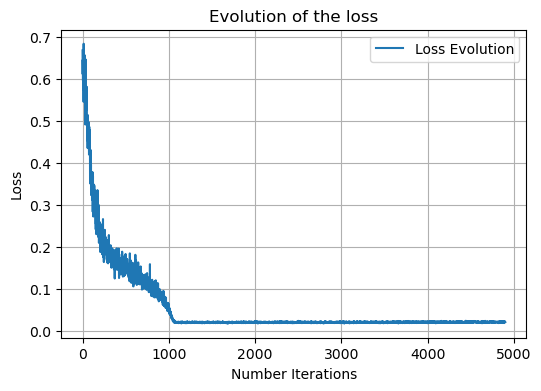

In [595]:
plt.figure(figsize=(6, 4))  # Par exemple, 8 pouces x 6 pouces
plt.plot(loss_data[100:],label="Loss Evolution")
plt.grid()
plt.xlabel("Number Iterations")
plt.ylabel("Loss")
plt.title("Evolution of the loss")
plt.legend()
plt.savefig("images/LossLinearQuadraticControlProblem.png")

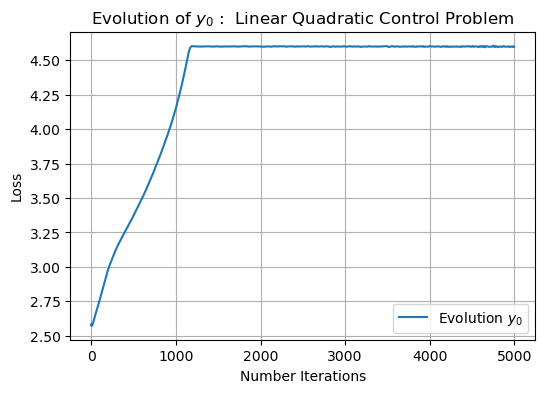

In [596]:
plt.figure(figsize=(6, 4))  # Par exemple, 8 pouces x 6 pouces
plt.plot(y0_data,label="Evolution $y_0$")
plt.grid()
plt.xlabel("Number Iterations")
plt.ylabel("Loss")
plt.title("Evolution of $y_0$ :  Linear Quadratic Control Problem")
plt.legend()
plt.savefig("images/y0LinearQuadraticControlProblem.png")

In [592]:
def estimate_solution(mc_iter=1e5):
        def g(x):
            norm_squared = np.linalg.norm(x,axis=1) ** 2  
            return np.log(0.5* (1+ norm_squared))  
        
        
        W = np.random.normal(loc=0.0, scale=np.sqrt(1), size=(int(mc_iter), dim_x))
        X_T = 0 + sigma_value * W
        this_mean = -np.log(np.mean(np.exp(-g(X_T))))
        return this_mean

In [593]:
print("Approximate value of Linear Quadratic control problem with Deep BSDE : " + str(np.round(y0_data[-1],4)))
print("Estimate true value : " + str(np.round(estimate_solution(),4)))

Approximate value of Linear Quadratic control problem with Deep BSDE : 4.5988
Estimate true value : 4.5901


<h3> I encourage you to make your own experiments by changing the functions $b$,$\sigma$, $f$ and $g$ for you own purposes and check the accuracy of the algorithm  ! </h3>

<a id=references></a>
<h2> <center> References : </center> </h2>

$\bullet$ $\textit{Germain, Pham, Warin: "Neural networks-based algorithms for stochastic control and PDEs"}$, 2023 available [here](https://arxiv.org/pdf/2101.08068)

$\bullet$ $\textit{Bachouch, Huré, Langrené, Pham : "Deep neural networks algorithms for stochastic control problems on finite horizon: numerical applications"}$,  2019 available [here](https://arxiv.org/pdf/1812.05916)

$\bullet$ $\textit{Huré, Pham, Bachouch, Langrené : "Deep neural networks algorithms for stochastic control problems on finite horizon: convergence analysis"}$,  2019 available [here](https://arxiv.org/pdf/1812.04300)

$\bullet$ $\textit{E, Han, Jentzen : "Deep learning-based numerical methods for high-dimensional parabolic partial differential equations and backward stochastic differential equations"}$, 2017 available [here](https://arxiv.org/pdf/1706.04702)

$\bullet$ $\textit{Sirignano, Spiliopoulos : DGM: A deep learning algorithm for solving partial differential equations"}$, 2017 available [here](https://arxiv.org/pdf/1708.07469)